In [1]:
# This program uses Support Vector Machines with 10-fold cross-validation with the Iris data set

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
from sklearn import datasets, svm
from sklearn.preprocessing import StandardScaler

from math import sqrt

In [3]:
class svm_iris(object):
    
    """
    A class to use the data from Iris data set and implement SVM to make multiclass predictions.
    Dimensionality reduction is performed via PCA. Different kernels might be used with additional
    hyperparametric optimisation and 10-fold cross-validation. Data plots could be invoked at will too.
    
    ...

    Attributes
    ----------
    path_to_data: df
        Pandas Data Frame with the Iris data.
    pca: obj
        PCA object.
    df_pca_scores: df
        Pandas Data Frame with the PCA scores.
    pca_varsum_95: float
        Variance sum of PCs containing >= 0.95 of the total variance.
    num: int
        Number of PCs containing >= 0.95 of the total variance.
    X_train, X_test, y_train , y_test, y_pred: df
        Data sets for train and test with their target variables.
    krnl: list
        List with the possible kernel choices.
    cost: list
        List with the possible cost values.
    k: str
        User prompt for the kernel choice.
    poly: bool
        Use at the reuqired prompt as True only for kernel type polynomial, else set to False.
        If True, the kernel degree will be set to 3. 
    cv_score: float
        The 10-fold cross-validation score.
    clf: obj
        Classifier object.
    summary: obj
        Summary with classification metrics.
    cm: obj
        The confusion matrix. 
        
        
    
    Methods
    -------
    load_data():
        Loads the data and outputs the df.
    fit_pca():
        Computes the PCA and gets the PC scores. Evaluates the number of PC needed to
        reach 0.95 of the total variance in the data.
    plot_pca():
        Uses pairplot for all PCs.
    split_rnd():
        Splits the data at random.
    kernel_choice():
        Steps to select/initiate the kernel choice. 
    hypar_opt():
        Performs hyperparamteric optimization, based on the choice from the kernel_choice() method.
    train_predict():
        Performs the training and the prediction, based on the choice from the kernel_choice() method.
    plot_svm():
        Plots the decision boundaries, based on the choice from the kernel_choice() method. 
        
    """
    
    
    __slots__ = ['df','pca','df_pca_scores','pca_varsum_95', 'num',
                 'X_train','X_test','y_train','y_test','y_pred',
                 'krnl','cost','k','poly','cv_score','best_c',      
                 'clf','summary','cm']
    
    
    def __init__(self):
        pass
    
    def load_data(self):
        
        df = pd.DataFrame(data = datasets.load_iris().data, 
                          columns = datasets.load_iris().feature_names)
        
        target = pd.DataFrame(datasets.load_iris().target)
        
        self.df = pd.concat([df, target], axis = 1, ignore_index = True)
        self.df.columns = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']
        
    def fit_pca(self):
        
        self.pca = PCA()
        self.pca = self.pca.fit(self.df.iloc[:,:-1])
        
        colnames = []
        
        for ii in range(4):
            colnames.append(f'PC{ii+1}')
                        
        self.df_pca_scores = pd.DataFrame(self.df.iloc[:,:-1] @ self.pca.components_)
        self.df_pca_scores.columns = colnames
        
        print('\n', 'Variance explained in PCs [%]:', '\n', self.pca.explained_variance_ratio_ * 100)
        
        self.pca_varsum_95 = 0
        ii = 0
        
        while self.pca_varsum_95 < 95:
            self.pca_varsum_95 += self.pca.explained_variance_ratio_[ii] * 100 
            ii += 1
        
        print(f'\n{self.pca_varsum_95:.2f}% of the total variance explained in {ii}({len(self.pca.explained_variance_ratio_)}) principal components')
        self.num = int(input("Enter number of PCs to use for fitting the model:"))
        
    def plot_pca(self):
        
        data_tmp = pd.concat([self.df_pca_scores, self.df['target']], axis = 1, ignore_index = True)
        data_tmp.columns = ['PC1','PC2','PC3','PC4','target']
        
        sns.pairplot(data = data_tmp, hue = 'target',
                     palette = 'turbo', markers = ['o','s','D'], corner = True)
        print('Class names: Iris-setosa -- 0, Iris-versicolor -- 1, Iris-virginica -- 3')
        
        del data_tmp
        
    def split_rnd(self):
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df_pca_scores.iloc[:,:self.num], 
                                                                                (self.df.target).astype('category'), 
                                                                                train_size = (100/150),
                                                                                test_size =  (50/150),
                                                                                random_state = 12)
        print('Train data size:\n', self.X_train.shape)
        print('Tеst data size:\n', self.X_test.shape)
        print('Train label size:\n', self.y_train.shape)
        print('Test label size:\n', self.y_test.shape)
        
    def kernel_choice(self):
        
        self.krnl = ["linear","poly","rbf"]
        self.cost = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        
        print('Available kernels:', self.krnl)
        print('Cost values:', self.cost)
        
        self.k = str(input("Select a kernel from the list:"))
        self.poly = str(input("True or False for polynomial kernel:"))
        
    def hypar_opt(self, k:str, c:float) -> None:
        
        if (k is None) or (c is None):
            raise TypeError ('Invalid None type for <<k>> and/or <<c>>. String values expected for k and float/int values for c.')
    
        if type(k) is not str:
            raise TypeError ('Invalid type for <<k>>. String values expected for k.')
            
        for c in self.cost:
            if self.poly == True:
                clf = svm.SVC(C = c, kernel = k, degree = 3, gamma = 'scale')
                cv_score = np.mean(cross_val_score(clf, self.X_train, self.y_train, cv = 10))
            else:
                clf = svm.SVC(C = c, kernel = k, gamma = 'scale')
                cv_score = np.mean(cross_val_score(clf, self.X_train, self.y_train, cv = 10))
            yield cv_score

    def plot_cost(self, k:str, c:float) -> None:
        
        if (k is None) or (c is None):
            raise TypeError ('Invalid None type for <<k>> and/or <<c>>. String values expected for k and float/int values for c.')
        
        if type(k) is not str:
            raise TypeError ('Invalid type for <<k>>. String values expected for k.')
            
        self.cv_score = list(self.hypar_opt(k,c))
        
        plt.figure()
        plt.scatter(x = [ii for ii in c], y = self.cv_score)
        plt.title(f'SVM evaluation for {k} kernel',size = 15)
        plt.xlabel('$Cost$', size = 15)
        plt.ylabel('Scores', size = 15)
        plt.show()
        
        self.best_c = c[self.cv_score.index(np.max(self.cv_score))] 
        
        print('Best value for C =', self.best_c)
        
    def train_predict(self, k:str) -> None:
        
        if k is None:
            raise TypeError ('Invalid None type for <<k>>. String values expected for k.')
            
        if type(k) is not str:
            raise TypeError ('Invalid type for <<k>>. String values expected for k.')
            
        if self.poly == True:
            self.clf = svm.SVC(C = self.best_c, kernel = k, degree = 3, gamma = 'scale')
        else:
            self.clf = svm.SVC(C = self.best_c, kernel = k, gamma = 'scale')
            
        self.clf = self.clf.fit(self.X_train.values, self.y_train.values)    
        self.y_pred = self.clf.predict(self.X_test.values)
        self.summary = classification_report(self.y_test, self.y_pred)
        self.cm = confusion_matrix(self.y_test, self.y_pred)
        
        print('\nSummary:\n',self.summary)        
        print('\nConfusion matrix:\n',self.cm)
        
        
    def plot_svm(self):
        
        def make_meshgrid():
            h = 0.02
            x_min, x_max = self.df_pca_scores['PC1'].min() - 1, self.df_pca_scores['PC1'].max() + 1
            y_min, y_max = self.df_pca_scores['PC2'].min() - 1, self.df_pca_scores['PC2'].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            return xx, yy

        def plot_contours(ax, clf, xx, yy, **params):
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            out = ax.contourf(xx, yy, Z, **params)
            return out

        xx, yy = make_meshgrid() 

        fig, ax = plt.subplots()
        plot_contours(ax, self.clf, xx, yy, cmap=plt.cm.turbo, alpha=0.8)
        ax.scatter(self.df_pca_scores['PC1'], self.df_pca_scores['PC2'], 
                   c=self.df.target, cmap=plt.cm.turbo, s=20, edgecolors='k')
        ax.set_ylabel('PC2', size=15)
        ax.set_xlabel('PC1', size=15)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(f'Separating plane for {self.k} kernel', size=15)
        ax.legend()
        plt.show()

In [4]:
vect = svm_iris()
vect.load_data()
vect.df.shape

(150, 5)

In [5]:
vect.fit_pca()


 Variance explained in PCs [%]: 
 [92.46187232  5.30664831  1.71026098  0.52121839]

97.77% of the total variance explained in 2(4) principal components
Enter number of PCs to use for fitting the model:2


Class names: Iris-setosa -- 0, Iris-versicolor -- 1, Iris-virginica -- 3


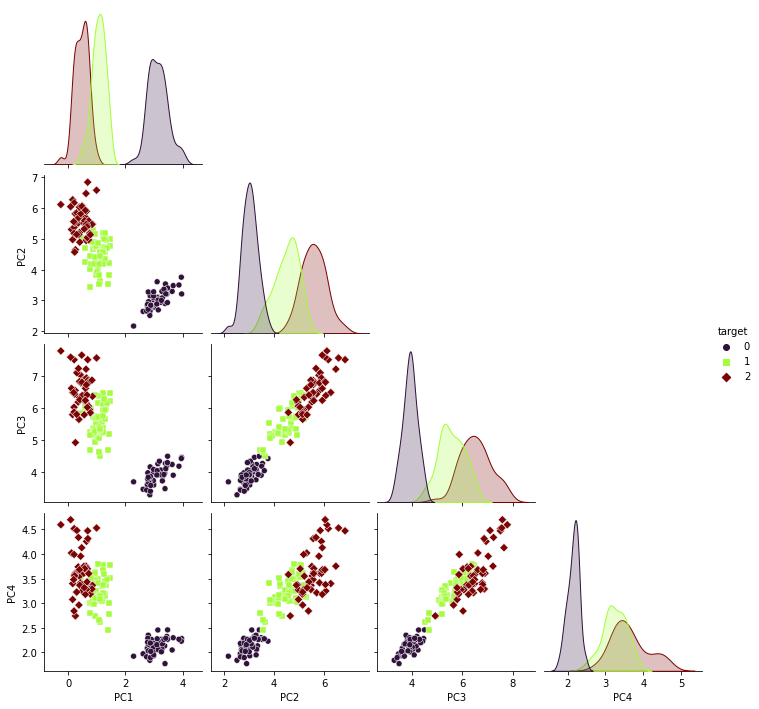

In [6]:
vect.plot_pca()

In [7]:
vect.split_rnd()

Train data size:
 (100, 2)
Tеst data size:
 (50, 2)
Train label size:
 (100,)
Test label size:
 (50,)


In [8]:
vect.kernel_choice()

Available kernels: ['linear', 'poly', 'rbf']
Cost values: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
Select a kernel from the list:poly
True or False for polynomial kernel:False


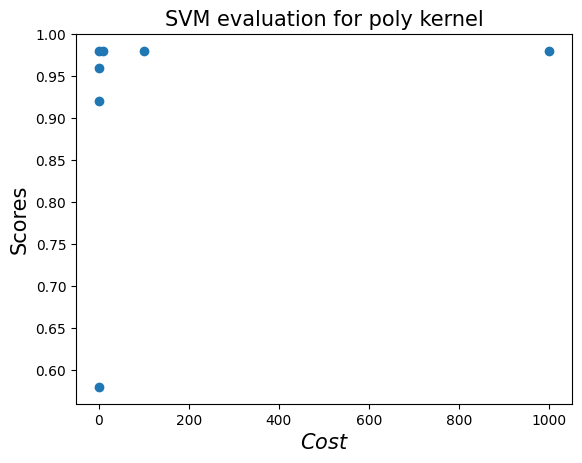

Best value for C = 1


In [9]:
vect.plot_cost(vect.k,vect.cost)

In [10]:
vect.train_predict(vect.k)


Summary:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      0.93      0.96        14
           2       0.92      1.00      0.96        12

    accuracy                           0.98        50
   macro avg       0.97      0.98      0.97        50
weighted avg       0.98      0.98      0.98        50


Confusion matrix:
 [[24  0  0]
 [ 0 13  1]
 [ 0  0 12]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


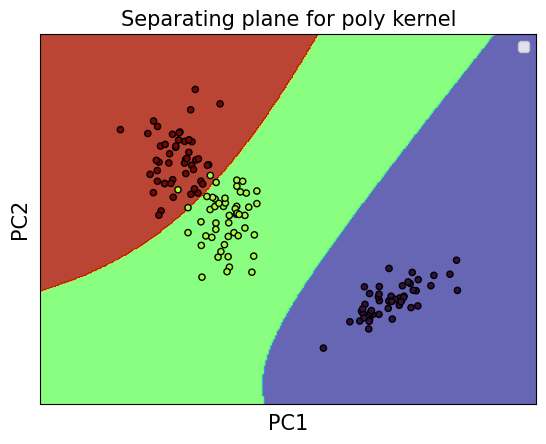

In [11]:
vect.plot_svm()